In [2]:
import openmc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

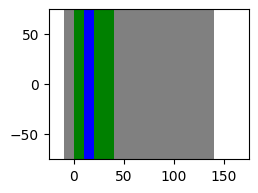

In [8]:
air = openmc.Material(name="air")
air.add_element('O',0.2)
air.add_element('N',0.8)
air.set_density('g/cm3',1.3e-3)

iron=openmc.Material(name="iron")
iron.add_element('O',1)
iron.set_density('g/cm3',7.874)

water=openmc.Material(name="water")
water.add_element('O',1)
water.add_element('H',2)
water.set_density('g/cm3',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

materials = openmc.Materials([air,iron,water])

domain = openmc.model.RectangularParallelepiped(-10,140,-100,100,-100,100,boundary_type='vacuum')

p1 = openmc.XPlane(x0=0.0)
p2 = openmc.XPlane(x0=10.0)
p3 = openmc.XPlane(x0=20.0)
p4 = openmc.XPlane(x0=40.0)
tally_plane = openmc.XPlane(x0=139.9)

air_left = openmc.Cell()
air_left.region = -domain & -p1
air_left.fill = air

shield1 = openmc.Cell()
shield1.region = -domain & +p1 & -p2
shield1.fill = iron

shield2 = openmc.Cell()
shield2.region = -domain & +p2 & -p3
shield2.fill = water

shield3 = openmc.Cell()
shield3.region = -domain & +p3 & -p4
shield3.fill = iron

air_right = openmc.Cell()
air_right.region = -domain & +p4 & -tally_plane
air_right.fill = air

tally_cell = openmc.Cell()
tally_cell.region = -domain & +tally_plane
tally_cell.fill = air

root_univ = openmc.Universe()
root_univ.add_cells([air_left,shield1,shield2,shield3,air_right,tally_cell])

geometry = openmc.Geometry()
geometry.root_universe = root_univ

materials.export_to_xml()
geometry.export_to_xml()

colors={}
colors[air]='grey'
colors[water]='blue'
colors[iron]='green'

root_univ.plot(origin=(75,0,0),width=(200,150),color_by='material',colors=colors)


In [9]:
#Add a tally to estimate the dose at the rifht side of the domain
flux = openmc.Tally(name='flux')

energy,dose = openmc.data.dose_coefficients('neutron','AP')
dose_filter = openmc.EnergyFunctionFilter(energy,dose)
surface_filter = openmc.SurfaceFilter(tally_plane)

flux.filters = [dose_filter,surface_filter]
flux.scores = ['current']

tallies = openmc.Tallies([flux])
tallies.export_to_xml()

In [11]:
point = openmc.stats.Point((-5,0,0))
energy = openmc.stats.Watt(a=1.025e6,b=2.926e-6)

source = openmc.Source(space=point, energy=energy)

settings = openmc.Settings()
settings.run_mode = 'fixed source'
settings.batches = 100
settings.particles = 30000
settings.generations_per_batch = 100
settings.source = source

settings.export_to_xml()

In [12]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [15]:
sp = openmc.StatePoint('statepoint.100.h5')
sp.tallies

dose_t = sp.get_tally(name='flux')
dose_df = dose_t.get_pandas_dataframe()
dose_df.head()

current = dose_df['mean']
std_dev = dose_df['std. dev.']

source_strength = 3e8
conv_pSv_to_rem = 1e-10
time = 3600
surf_area = 200.*200.

current = current*conv_pSv_to_rem*source_strength*time/surf_area

print('the dose is approximately %6.4g rem/hr' % current)

the dose is approximately 0.0002306 rem/hr


/tmp/ipykernel_24315/4234010742.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('the dose is approximately %6.4g rem/hr' % current)
